<a href="https://colab.research.google.com/github/borgesjose/evolutionary-algorithms/blob/main/sAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade  

In [ ]:
pip install ypstruct

Script Algoritmo Genéticos:

In [ ]:
#######################################################  
# Universidade Federal do Piauí                       #
# Campus ministro petronio Portela                    #                                       
# Copyright 2020 -José Borges do Carmo Neto-          #
# @author José Brges do Carmo Neto                    #
# @email jose.borges90@hotmail.com                    #
#  -- Algoritmo Genético Básico                       #
#  -- Version: 0.2  - 27/11/2020                      #
#######################################################

import random
import numpy as np
from ypstruct import structure
from functools import reduce

def runAG(problem,params):
    
    costfunc = problem.costfunc
    nvar = problem.nvar
    varmin = problem.varmin
    varmax = problem.varmax
    beta = params.beta
    maxit = params.maxit
    npop = params.npop
    size_cromossomo = params.size_cromossomo
    size_dec = params.size_dec
    size_int = params.size_int

    pc = params.pc
    nc = int(np.round(pc*npop/2)*2)
    gamma = params.gamma
    mu = params.mu
    sigma = params.sigma
    selection_flag = params.selection_flag
    N = params.torneio_size

    count_avaliacoes = 0

    # definido o individio;
    individuo_vazio = structure()
    individuo_vazio.cromossomo = None
    individuo_vazio.custo = None
    
    #Melhor Solução:
    the_best = individuo_vazio.deepcopy()
    the_best.custo = np.inf


    #Criando uma população inicial:
    pop = individuo_vazio.repeat(npop)
    for i in range(0,npop):
        pop[i].cromossomo = np.random.randint(2, size=size_cromossomo)
        #print(pop[i].cromossomo)
        pop[i].custo = costfunc(bin_to_real(pop[i].cromossomo, size_int,  size_dec))
        count_avaliacoes = count_avaliacoes + 1
        
        if pop[i].custo < the_best.custo:
            the_best = pop[i].deepcopy()

  
    #Melhor custo por iterações:
    the_best_costs = np.empty(maxit)

    #Vamo botar pra Rodar:
    for it in range(maxit):
        
        custos = np.array([x.custo for x in pop])
        avg_cost = np.mean(custos)
        if avg_cost != 0:
            custos = custos/avg_cost
        
        probs = np.exp(-beta*custos)

        popc = []
        for k in range(nc//2):
            q = np.random.permutation(npop)
            
            if selection_flag == 'r':
                #Seleção po roleta
                p1 = pop[roda_roda_jequiti(probs)]
                p2 = pop[roda_roda_jequiti(probs)]
            if selection_flag == 't':
                p1 = pop[mortal_combat(N,pop)] 
                p2 = pop[mortal_combat(N,pop)]

            #Fazer o crossover:
            c1,c2  = crossover(p1,p2,gamma)
            #Fazer Mutação
            c1 = mutacao(c1, mu, sigma)
            c2 = mutacao(c2, mu, sigma)

            # Tudo tem limite
            apply_bound(c1, varmin, varmax,size_int)
            apply_bound(c2,varmin, varmax,size_int)

            # Avaliar filhos
            c1.custo = costfunc(bin_to_real(c1.cromossomo, size_int,  size_dec))
            count_avaliacoes = count_avaliacoes + 1
            if c1.custo < the_best.custo:
                the_best = c1.deepcopy()
            c2.custo = costfunc(bin_to_real(c2.cromossomo,size_int,  size_dec))
            count_avaliacoes = count_avaliacoes + 1
            if c2.custo < the_best.custo:
                the_best = c2.deepcopy()

            # Adicionar filhos a população
            popc.append(c1)
            popc.append(c2)

        pop += popc
        #print(pop)
        pop = sorted(pop, key=lambda x: x.custo)
        #print(pop)
        pop = pop[0:npop]
      

        #Armazenar o melhor custo por iteração
        the_best_costs[it] = the_best.custo

        #Mostrar situação atual
        #print("Iteração {}: Melhor Custo = {}".format(it, the_best_costs[it]))

    
    n_bits_corretos = contador_de_zeros(the_best.cromossomo[1:])

    #saida
    saida = structure()
    saida.pop = pop
    saida.the_best = the_best
    saida.the_best_costs  = the_best_costs 
    saida.custos = custos
    saida.count_avaliacoes = count_avaliacoes;
    saida.n_bits_corretos = n_bits_corretos;

    return saida

def bin_to_real(x,int,dec):
    real=0
    bin = x[::-1]
    for i in range(bin.size-1):
        real =  real + bin[i]*2**(-dec+i)
    if x[0]==1:
        real = real
    if x[0] == 0:
        real=-1*real  
    return real

def real_to_bin(real,n=0): #Retoran um binario com bit de sinal
    #n é o numero de bits
    restos = []
    if real > 0:
        sinal = 1
    if real < 0:
        sinal = 0
    r = abs(real)
    while abs(r) > 0:
        resto = r%2
        restos.append(resto)
        r=r//2

    if n > len(restos):
      m = n - len(restos)
      for uu in range(m):
          restos.append(0)

    restos.append(sinal)
    restos.reverse()
    bin = np.array(restos)     
    return bin

def crossover(p1,p2,gamma = 0.1):
    c1 = p1.deepcopy()
    c2 = p1.deepcopy()
    point = np.random.randint(1,p1.cromossomo.size)

    c1.cromossomo = np.concatenate((p1.cromossomo[:point], p2.cromossomo[point:]))
    c2.cromossomo = np.concatenate((p2.cromossomo[:point], p1.cromossomo[point:]))

    return c1,c2

def mutacao(x,mu,sigma):
    #mu = probabilidade de mutar o individuo;
    #sigma probabilidade de um bit mudar;
    y = x.deepcopy()
    prb = np.random.rand()
    if prb<=mu:
        for kk in range(y.cromossomo.size):
            prbb = np.random.rand()
            if prbb <= sigma:
                y.cromossomo[kk] = inverter(y.cromossomo[kk])
    return  y


def roda_roda_jequiti(p):
    #Função que faz a seleção pela roleta:
    c = np.cumsum(p)
    r = sum(p)*np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]

def mortal_combat(N,pop):
    #função que faz seleção por torneio:
    npop = len(pop)
    indices_torneio = np.zeros(N)
    custos_torneio = np.zeros(N)
    for ii in range(N): #Seleção da população para o torneio
        point =  random.randrange(0, npop)
        indices_torneio[ii] = point
        custos_torneio[ii] = pop[point].custo
    
    champ = int(indices_torneio[np.argmax(custos_torneio)]) #Test your might
      
    return champ #retorna o indice na população do campeão deste torneio

def apply_bound(x,varmin, varmax,size_int):
    num = bin_to_real(x.cromossomo[:size_int+1],size_int,0)
    #print('num antes de aplicar bound:',num)
    #print(x.cromossomo[:size_int+1])
    if num > varmax:
        x.cromossomo[:size_int+1] = real_to_bin(varmax,size_int)
    if num < varmin:
        x.cromossomo[:size_int+1] = real_to_bin(varmin,size_int)
    num1= bin_to_real(x.cromossomo[:size_int+1],size_int,0)
    #print('num após aplicar bound:',num1)

def inverter(x):
    if x ==1:
        y=0
    if x==0:
        y=1
    return y

def contador_de_zeros(x):
    count = np.count_nonzero(x==0)
    return count


In [ ]:
print(saida.the_best.custo)

In [ ]:
print(saida.the_best.cromossomo)

In [ ]:
plt.plot(range(params.maxit),saida.the_best_cost)
plt.title('CUSTO x GERAÇÂO')

## Experimento com Seleção por Roleta:

Segundo 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ypstruct import structure 
import pandas as pd
import time

# Função objetivo:
def x_quadrado(x):
    return x**2
n_execucao = 1;

Devemos obter as seguites informações do algoritmo:

    1 - Numero de Bits correntos (Quantidade de zeros na resposta final em média ao fim de cada rodada) para 5 execuções do AG:
    2 -  Numero de Avaliações médio para 5 execuções do AG 
    3 - valor de fit médio para 5 execuçãoes do AG

In [ ]:
nicio = time.time()

problem = structure()
problem.objetivo = 'min'
problem.costfunc = x_quadrado
problem.nvar = 1
problem.varmin = -250
problem.varmax = 250

params = structure()
params.maxit = 5
params.size_int = 9;
params.size_dec = 10;
params.size_cromossomo = 1+params.size_int+params.size_dec

params.selection_flag = 'r'
params.torneio_size = 10


resultados = []

taxas_de_mutação = [0.0,0.01,0.02,0.05,0.10,0.20,0.25,0.50]

for muts in taxas_de_mutação:

    params.mu = muts #taxa de mutação
    params.sigma = 0.5 #probabilidade de mudar um bit


    Bit_corretos_colunas = []
    valor_fit_colunas = []
    numero_avaliacao_colunas = []

    populacoes = [10,500,1000,1500,2000,2500,3000,4000,5000]
    for pops in populacoes:
        params.npop = pops

        qt_bits_corretos = []
        valor_fit = []
        numero_avaliacao = []
        taxas_de_cruzamento = [1.0, 0.90, 0.75, 0.50, 0.25, 0.10, 0.0]
        for crz in taxas_de_cruzamento:
            
            saida = []
            for ll in range(n_execucao):
                params.beta = 1
                params.pc = 1
                params.gamma = crz #taxa de crossover
                
                saida.append(runAG(problem,params))

            for x in saida:
                media_bits_corretos = np.mean(x.n_bits_corretos)
                media_fit = np.mean(x.the_best.custo)
                media_avaliacoes = np.mean(x.count_avaliacoes)
                #print(' A média do numero de bits corretos é:  ',media_bits_corretos)
                #print('A média do Fit: ',media_fit)
                #print('A média do Numero de Avaliações: ', media_avaliacoes)

            
            qt_bits_corretos.append(media_bits_corretos)
            valor_fit.append(media_fit)
            numero_avaliacao.append(media_avaliacoes)

        Bit_corretos_colunas.append(qt_bits_corretos)
        valor_fit_colunas.append(valor_fit)
        numero_avaliacao_colunas.append(numero_avaliacao)


    Tabela_bit = pd.DataFrame(Bit_corretos_colunas).T
    Tabela_bit.columns = ['Pupulação = 10','Pupulação = 500','Pupulação = 1000','Pupulação = 1500','Pupulação = 2000','Pupulação = 2500','Pupulação =3000','Pupulação = 4000','Pupulação = 5000']
    Tabela_bit.index = ['Cruzamento = 100%','Cruzamento = 90%','Cruzamento = 75%','Cruzamento = 50%','Cruzamento = 25%','Cruzamento = 10%','Cruzamento = 0%']

    Tabela_fit = pd.DataFrame(valor_fit_colunas).T
    Tabela_fit.columns = ['Pupulação = 10','Pupulação = 500','Pupulação = 1000','Pupulação = 1500','Pupulação = 2000','Pupulação = 2500','Pupulação =3000','Pupulação = 4000','Pupulação = 5000']
    Tabela_fit.index = ['Cruzamento = 100%','Cruzamento = 90%','Cruzamento = 75%','Cruzamento = 50%','Cruzamento = 25%','Cruzamento = 10%','Cruzamento = 0%']

    Tabela_ava = pd.DataFrame(numero_avaliacao_colunas).T
    Tabela_ava.columns =['Pupulação = 10','Pupulação = 500','Pupulação = 1000','Pupulação = 1500','Pupulação = 2000','Pupulação = 2500','Pupulação =3000','Pupulação = 4000','Pupulação = 5000']
    Tabela_ava.index = ['Cruzamento = 100%','Cruzamento = 90%','Cruzamento = 75%','Cruzamento = 50%','Cruzamento = 25%','Cruzamento = 10%','Cruzamento = 0%']


    resultados.append([Tabela_bit,Tabela_fit,Tabela_ava])
    

    Tabela_bit.to_csv("Tabela_bit_TX_MUT_"+str(params.mu)+".csv", sep=';')
    Tabela_fit.to_csv("Tabela_fit_TX_MUT_"+str(params.mu)+".csv", sep=';')
    Tabela_ava.to_csv("Tabela_ava_TX_MUT_"+str(params.mu)+".csv", sep=';')

fim = time.time()
print('tempo execução:',fim - inicio)

tempo execução: 14741.438331127167


In [ ]:

Tabela_bit

,Pupulação = 10,Pupulação = 500,Pupulação = 1000,Pupulação = 1500,Pupulação = 2000,Pupulação = 2500,Pupulação =3000,Pupulação = 4000,Pupulação = 5000
Cruzamento = 100%,12.0,17.0,14.0,16.0,19.0,17.0,18.0,17.0,18.0
Cruzamento = 90%,11.0,17.0,14.0,16.0,16.0,18.0,15.0,18.0,16.0
Cruzamento = 75%,16.0,16.0,17.0,15.0,17.0,18.0,18.0,19.0,18.0
Cruzamento = 50%,13.0,16.0,14.0,17.0,16.0,18.0,17.0,18.0,18.0
Cruzamento = 25%,13.0,17.0,17.0,15.0,15.0,16.0,18.0,17.0,18.0
Cruzamento = 10%,13.0,13.0,17.0,15.0,18.0,19.0,17.0,18.0,17.0
Cruzamento = 0%,12.0,14.0,17.0,19.0,17.0,17.0,19.0,18.0,18.0


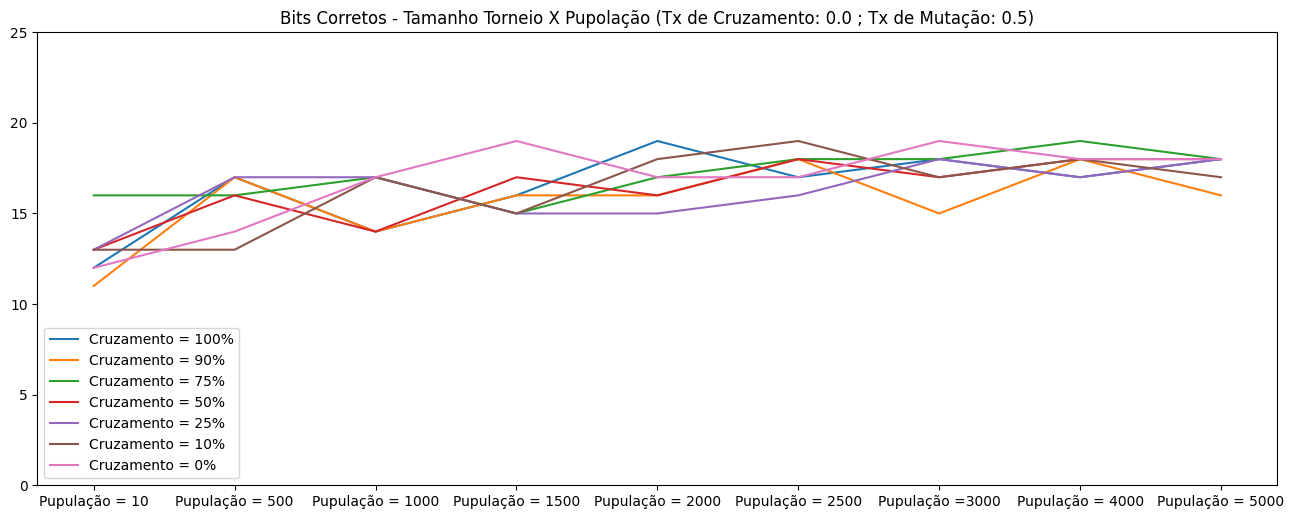

In [ ]:
plt.figure(num=None, figsize=(16, 6), dpi=100, facecolor='w', edgecolor='k')
for w in range(1,len(Tabela_bit)+1):
    plt.plot(Tabela_bit[w-1:w].T)
plt.legend(Tabela_bit.index)
plt.ylim([0,25])
plt.title("Bits Corretos - Tamanho Torneio X Pupolação (Tx de Cruzamento: "+str(params.gamma) +" ; Tx de Mutação: "+str(params.mu) +")")
plt.savefig( "bit_TX_MUT_"+str(params.mu)+'.png', dpi=100)

## Experimento com Seleção por Torneio:



In [ ]:
inicio = time.time()

problem = structure()
problem.objetivo = 'min'
problem.costfunc = x_quadrado
problem.nvar = 1
problem.varmin = -4
problem.varmax = 4

params = structure()
params.maxit = 5
params.size_int = 3;
params.size_dec = 10;
params.size_cromossomo = 1+params.size_int+params.size_dec

params.selection_flag = 't'

#mutação
taxas_de_mutação = [0.1]#,0.01,0.02,0.05,0.10,0.20,0.25,0.50]

for mut in taxas_de_mutação:
    params.mu = mut #taxa de mutação
    params.sigma = 0.5 #probabilidade de mudar um bit

    #cruzamento
    taxas_de_cruzamento = [1.0, 0.90, 0.75, 0.50, 0.25, 0.10, 0.0]

    for crz in taxas_de_cruzamento:
        
        params.beta = 1
        params.pc = 1
        params.gamma = crz #taxa de crossover


        Bit_corretos_colunas = []
        valor_fit_colunas = []
        numero_avaliacao_colunas = []

        populacoes = [10,500,1000,1500,2000,2500,3000,4000,5000]
        for pops in populacoes:
            params.npop = pops

            qt_bits_corretos = []
            valor_fit = []
            numero_avaliacao = []
            tamanho_torneio = [2,4,8,16]
            for torn in tamanho_torneio:
                params.torneio_size = torn
                saida = []
                for ll in range(n_execucao):
                    
                    saida.append(runAG(problem,params))

                for x in saida:
                    media_bits_corretos = np.mean(x.n_bits_corretos)
                    media_fit = np.mean(x.the_best.custo)
                    media_avaliacoes = np.mean(x.count_avaliacoes)


                
                qt_bits_corretos.append(media_bits_corretos)
                valor_fit.append(media_fit)
                numero_avaliacao.append(media_avaliacoes)

            Bit_corretos_colunas.append(qt_bits_corretos)
            valor_fit_colunas.append(valor_fit)
            numero_avaliacao_colunas.append(numero_avaliacao)


        Tabela_bit = pd.DataFrame(Bit_corretos_colunas).T
        Tabela_bit.columns = ['Pupulação = 10','Pupulação = 500','Pupulação = 1000','Pupulação = 1500','Pupulação = 2000','Pupulação = 2500','Pupulação =3000','Pupulação = 4000','Pupulação = 5000']
        Tabela_bit.index = ['Torneio=2','Torneio=4','Torneio=8','Torneio=16']

        Tabela_fit = pd.DataFrame(valor_fit_colunas).T
        Tabela_fit.columns = ['Pupulação = 10','Pupulação = 500','Pupulação = 1000','Pupulação = 1500','Pupulação = 2000','Pupulação = 2500','Pupulação =3000','Pupulação = 4000','Pupulação = 5000']
        Tabela_fit.index = ['Torneio=2','Torneio=4','Torneio=8','Torneio=16']

        Tabela_ava = pd.DataFrame(numero_avaliacao_colunas).T
        Tabela_ava.columns =['Pupulação = 10','Pupulação = 500','Pupulação = 1000','Pupulação = 1500','Pupulação = 2000','Pupulação = 2500','Pupulação =3000','Pupulação = 4000','Pupulação = 5000']
        Tabela_ava.index = ['Torneio=2','Torneio=4','Torneio=8','Torneio=16']


        Tabela_bit.to_csv("Bits-Tam_TorneioXPup "+"Tx_Cruz:"+str(params.gamma)+" Tx_Mut"+str(params.mu)+".csv", sep=';')
        Tabela_fit.to_csv("fit-Tam_TorneioXPup "+"Tx_Cruz:"+str(params.gamma)+" Tx_Mut"+str(params.mu)+".csv", sep=';')
        Tabela_ava.to_csv("AVAL-Tam_TorneioXPup "+"Tx_Cruz:"+str(params.gamma)+" Tx_Mut"+str(params.mu)+".csv", sep=';')



fim = time.time()
print('tempo execução:',fim - inicio)

tempo execução: 1165.9571824073792
